In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [35]:
!pip install contextily

In [5]:
# 1. Import required libraries
import pandas as pd #for data manipulation and analysis
import numpy as np ## For numerical operations and arrays
import matplotlib.pyplot as plt # For basic data visualization (line plots, bar charts, etc.)
import seaborn as sns  # For advanced statistical plots and prettier charts
import geopandas as gpd # For working with geographic data (GeoDataFrames, shapefiles)
import contextily as ctx # For adding basemaps (like OpenStreetMap) to geopandas plots
from geopy.geocoders import Nominatim # For geocoding (convert location name to coordinates)
from geopy.extra.rate_limiter import RateLimiter # To slow down geocoding requests and avoid getting blocked


In [14]:
# 2. Load dataset
df = pd.read_csv("/content/drive/MyDrive/Data Analysis final report and all/cleaned_nepal_earthquakes_2015_2025.csv")

In [39]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')  # Combine 'Date' & 'Time' → datetime; invalid → NaT
df.set_index('Datetime', inplace=True)  # Set 'Datetime' as DataFrame index for time-based operations


#Exploatory Data Analysis
We need to explore/clean/filter it before processing it for machine learning It involves adding/deleting few columns or rows, joining some other data, and handling qualitative variables like dates.

In [15]:
df.shape

(652, 8)

In [8]:
print("First 5 rows:")
print(df.head())

First 5 rows:
         Date             Time  Magnitude  Depth_km  Longitude  Latitude  \
0  2015-01-05  19:41:44.280000        4.2     34.47    81.6126   28.8652   
1  2015-01-22  03:42:38.040000        4.0     40.66    81.0522   29.3853   
2  2015-01-31  13:59:45.250000        4.8     32.41    83.9732   28.2987   
3  2015-04-02  00:56:38.960000        4.6     57.33    86.3309   28.7007   
4  2015-04-21  14:02:15.550000        5.0     10.00    82.3938   28.8947   

                          Place                 Datetime  
0    9 km WNW of Dailekh, Nepal  2015-01-05 19:41:44.280  
1    17 km NE of Dipayal, Nepal  2015-01-22 03:42:38.040  
2      3 km N of Pokhara, Nepal  2015-01-31 13:59:45.250  
3  89 km NNE of Kod?ri??, Nepal  2015-04-02 00:56:38.960  
4     46 km SSE of Jumla, Nepal  2015-04-21 14:02:15.550  


In [10]:
print("\nDataset shape:", df.shape)
print("\nDataset info:")
df.info()



Dataset shape: (652, 8)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652 entries, 0 to 651
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       652 non-null    object 
 1   Time       652 non-null    object 
 2   Magnitude  652 non-null    float64
 3   Depth_km   652 non-null    float64
 4   Longitude  652 non-null    float64
 5   Latitude   652 non-null    float64
 6   Place      652 non-null    object 
 7   Datetime   652 non-null    object 
dtypes: float64(4), object(4)
memory usage: 40.9+ KB


In [18]:
# Check how many missing (NaN) values are in the DataFrame
print(df.isnull().values.sum())

# Replace blank strings (" ") with actual missing values (np.nan)
df = df.replace(" ", np.nan)

# Check again how many missing values there are after replacement
print(df.isnull().values.sum())


0
0




*   Dataset contains 652 records with 8 features
*   Memory usages if 40.9 KB which is easy to process on local machine
*   The data seems to be clean with zero missing values
*   4 columns are int64 and 4 are string





In [28]:
# 7. Magnitude summary
print(f"Average Magnitude: {df['Magnitude'].mean():.2f}")
print(f"Min Magnitude: {df['Magnitude'].min()}")
print(f"Max Magnitude: {df['Magnitude'].max()}")


Average Magnitude: 4.47
Min Magnitude: 4.0
Max Magnitude: 7.8


the minimum magnitude of earthquake is 4.0, maximum magnitude of earthquake is 7.8 and average magnitude of earthquake is 4.47 magnitude.


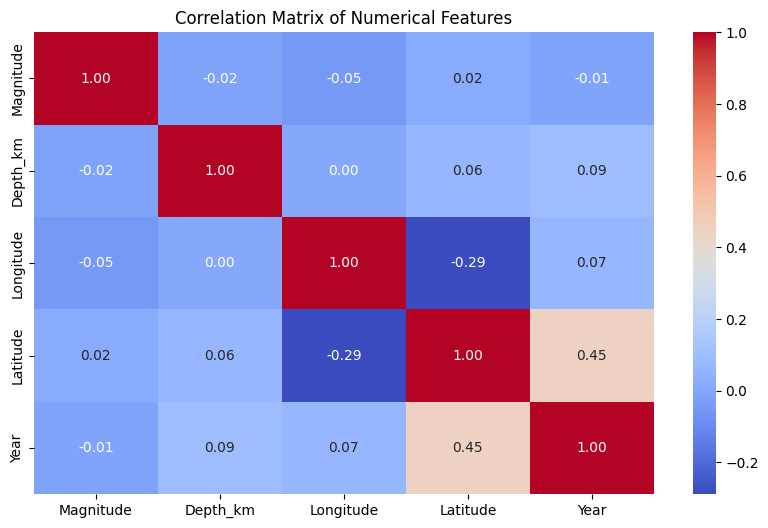

In [30]:
plt.figure(figsize=(10,6))                        # Create figure with size 10x6 inches
corr = df.corr(numeric_only=True)                  # Calculate correlation matrix for numeric columns only
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')  # Plot heatmap with annotations, coolwarm colors, 2 decimal places
plt.title("Correlation Matrix of Numerical Features")     # Add plot title
plt.savefig("correlation_matrix_heatmap.png", dpi=300, bbox_inches='tight')  # Save plot as PNG with high quality
plt.show()                                        # Display the plot


there's no strong linear relationship between location(lat/lon) and either magnitude or depth.

That's actually common in earthquake data:
Earthquake strength and depth depends more on underground fault structures and plates boundaries , tectonic stress, not just surface location.


<ipython-input-20-4042562051>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df.resample('M').size()          # Count earthquakes per month


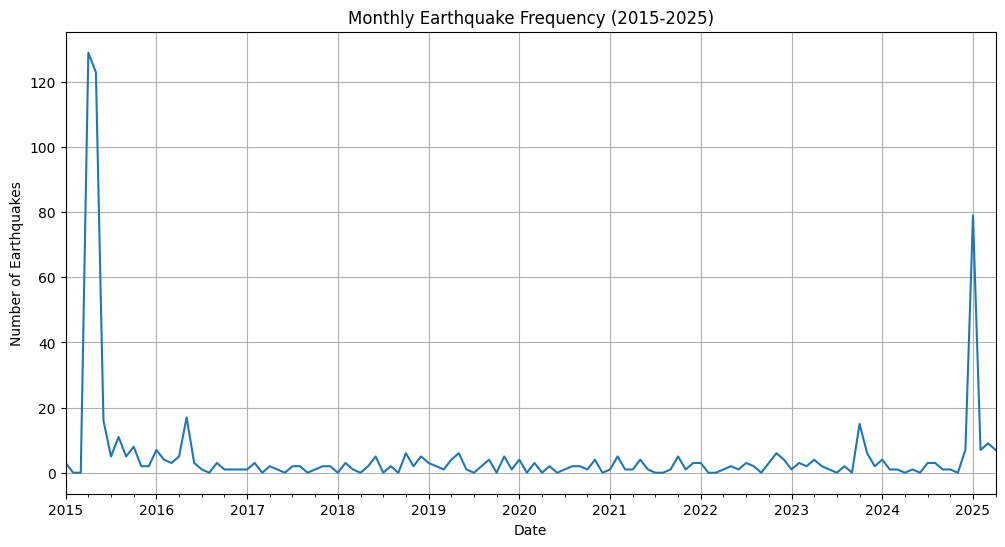

In [20]:
monthly_counts = df.resample('M').size()          # Count earthquakes per month
plt.figure(figsize=(12,6))                        # Set plot size
monthly_counts.plot(title="Monthly Earthquake Frequency (2015-2025)", xlabel="Date", ylabel="Number of Earthquakes")  # Plot line chart
plt.grid(True)                                    # Add grid lines
plt.savefig("monthly_earthquake_frequency.png", dpi=300, bbox_inches='tight')  # Save plot as PNG
plt.show()                                        # Show plot


The year 2015 shows an extreme spike in earthquake frequency, surpassing 120 events. This is directly related to the Gorkha Earthquake and its numerous aftershocks. In contrast, the years from 2016 to 2025 exhibit a significantly lower and stable earthquake frequency, typically under 20 events per year.

This trend suggests that 2015 was an outlier year, reflecting a major seismic event and not a sustained increase in seismicity.

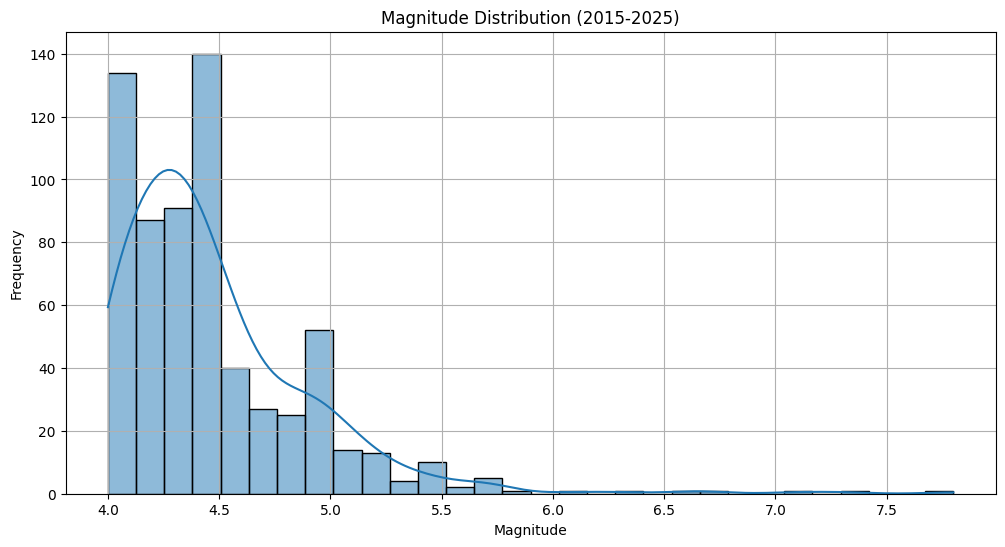

In [21]:
plt.figure(figsize=(12,6))                              # Set plot size
sns.histplot(df['Magnitude'], bins=30, kde=True)        # Plot histogram with 30 bins and KDE curve
plt.title("Magnitude Distribution (2015-2025)")         # Set plot title
plt.xlabel("Magnitude")                                  # Label x-axis
plt.ylabel("Frequency")                                  # Label y-axis
plt.grid(True)                                           # Add grid lines
plt.savefig("magnitude_distribution_histogram.png", dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()                                              # Display the plot



Based on the histogram of earthquake magnitudes (2015–2025), we can conclude that:

Most earthquakes were of low magnitude, mainly between 4.0 and 5.0.

As magnitude increases, the number of earthquakes decreases sharply, showing a right-skewed distribution.

High-magnitude earthquakes (above 6.5 or 7.0) were very rare, but they did occur during this period.

This pattern suggests that while frequent, most quakes were not severe — but occasional large quakes may have had a significant impact.

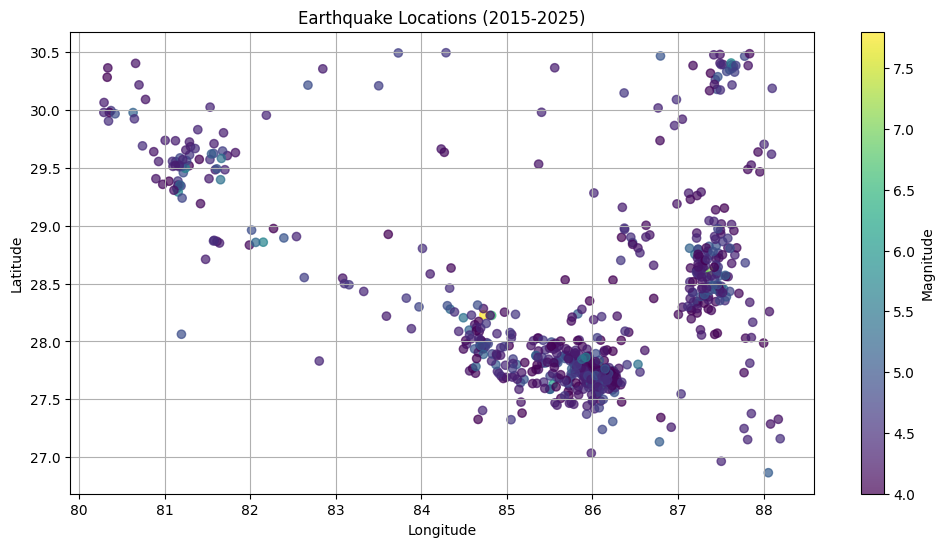

In [22]:
plt.figure(figsize=(12,6))                                     # Set plot size
plt.scatter(df['Longitude'], df['Latitude'],                   # Scatter plot of locations
            c=df['Magnitude'], cmap='viridis', alpha=0.7)      # Color points by magnitude with transparency
plt.colorbar(label='Magnitude')                                # Add color legend for magnitude
plt.title("Earthquake Locations (2015-2025)")                  # Plot title
plt.xlabel("Longitude")                                        # X-axis label
plt.ylabel("Latitude")                                         # Y-axis label
plt.grid(True)                                                 # Show grid
plt.savefig("earthquake_locations_scatter.png", dpi=300, bbox_inches='tight')  # Save plot as PNG
plt.show()                                                    # Display the plot


The scatter plot shows that earthquakes between 2015–2025 in Nepal were spatially concentrated in the central region (Lat ~28–28.5, Lon ~84–85), where the strongest (yellow) magnitudes occurred.

Lower magnitude quakes (blue shades) were more frequent and widespread across other areas.
This pattern indicates that the main seismic event (like Gorkha 2015) occurred centrally, followed by numerous smaller aftershocks or separate low-magnitude quakes in the surrounding region


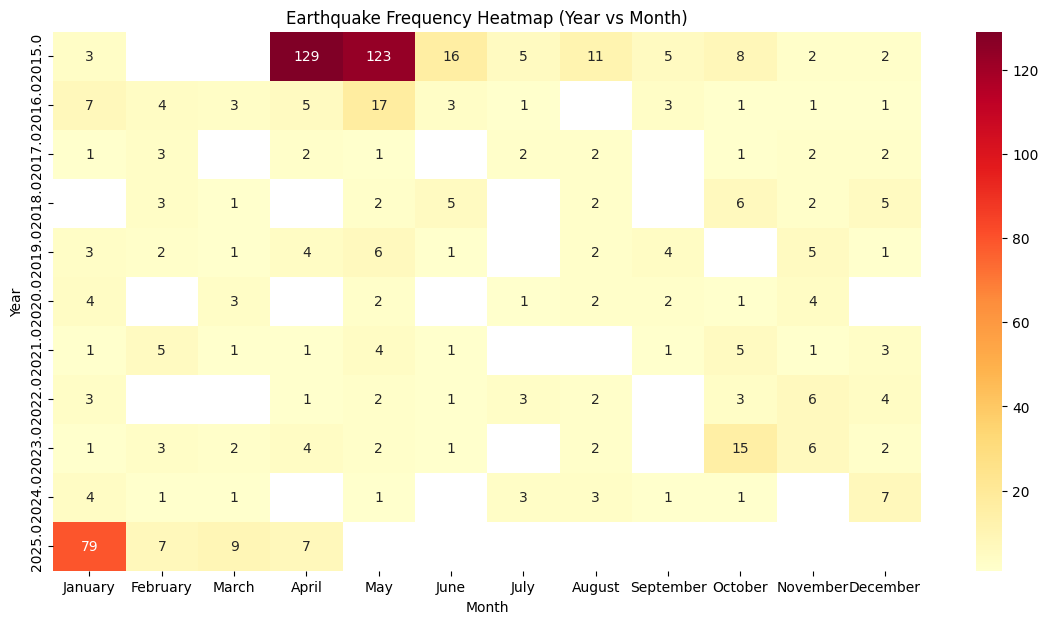

In [23]:
df['Year'] = df.index.year                           # Extract year from datetime index
df['Month'] = df.index.month_name()                  # Extract month name from datetime index

heatmap_data = df.pivot_table(                        # Create table counting earthquakes
    index='Year', columns='Month', values='Magnitude', aggfunc='count')

month_order = ['January', 'February', 'March', 'April', 'May', 'June',   # Define correct month order
               'July', 'August', 'September', 'October', 'November', 'December']
heatmap_data = heatmap_data[month_order]             # Reorder columns to correct month sequence

plt.figure(figsize=(14,7))                           # Set figure size
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd')  # Plot heatmap with numbers, color scheme
plt.title("Earthquake Frequency Heatmap (Year vs Month)")        # Title
plt.xlabel("Month")                                  # X-axis label
plt.ylabel("Year")                                   # Y-axis label
plt.savefig("earthquake_frequency_heatmap.png", dpi=300, bbox_inches='tight')  # Save plot_


The heatmap clearly shows major earthquake activity spikes in April and May 2015, likely related to the Gorkha earthquake and its aftershocks.
There is also a notable surge in January 2025, indicating a possible new seismic cluster or significant activity.
Apart from these peaks, earthquake frequency remains relatively low and stable throughout the years and months.

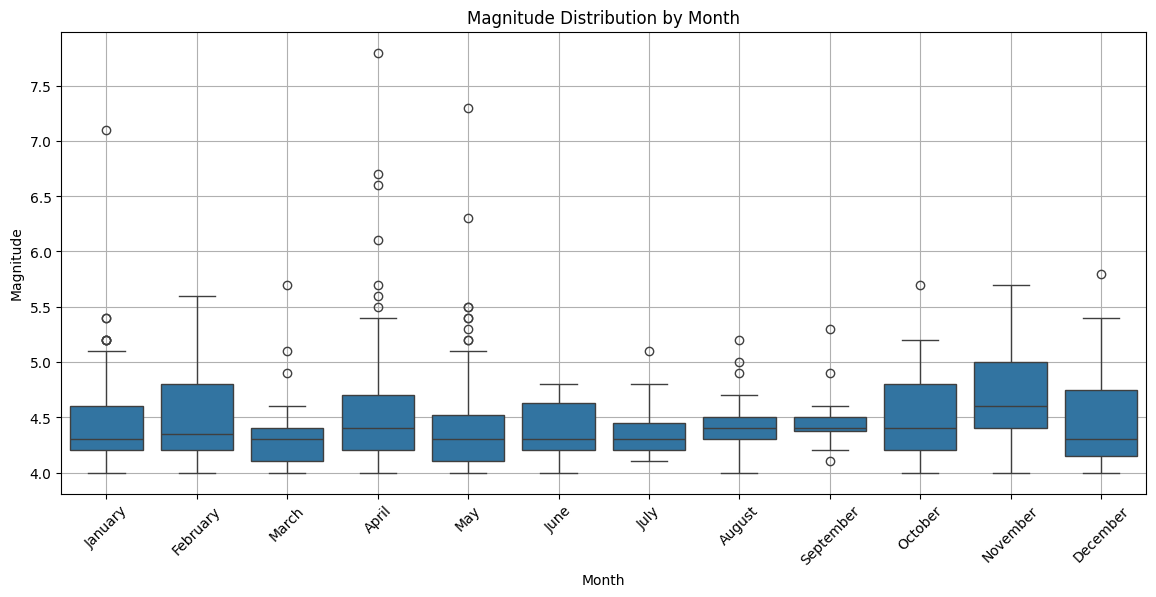

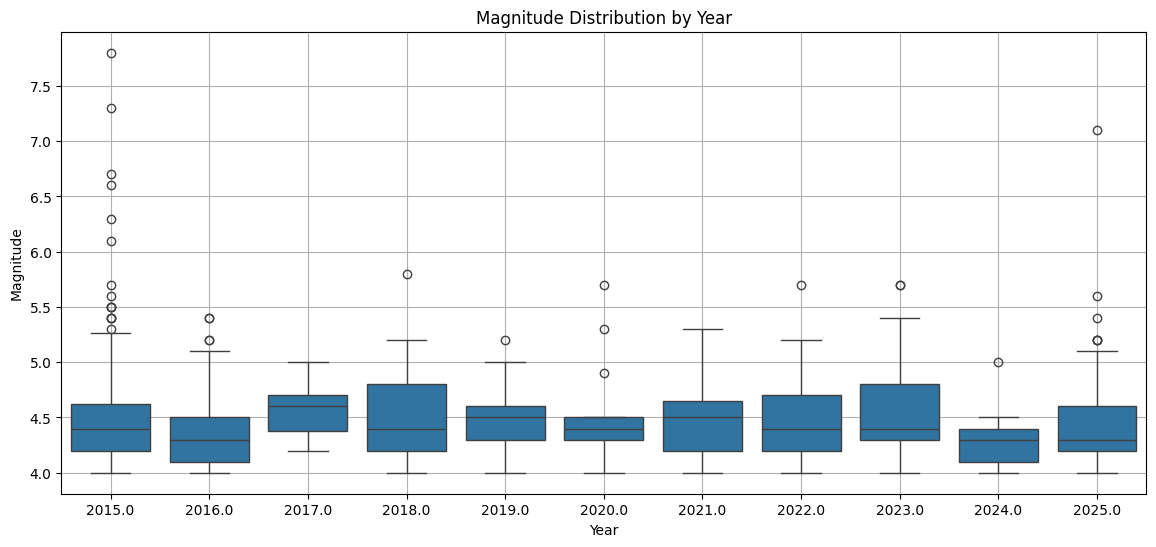

In [24]:
#  Boxplot by Month
plt.figure(figsize=(14,6))                                  # Set figure size
sns.boxplot(x='Month', y='Magnitude', data=df, order=month_order)  # Boxplot magnitude by month in correct order
plt.title("Magnitude Distribution by Month")                # Title
plt.xlabel("Month")                                          # X-axis label
plt.ylabel("Magnitude")                                      # Y-axis label
plt.xticks(rotation=45)                                      # Rotate month labels for readability
plt.grid(True)                                               # Show grid
plt.savefig("magnitude_distribution_by_month_boxplot.png", dpi=300, bbox_inches='tight')  # Save plot
plt.show()                                                  # Show plot

#  Boxplot by Year
plt.figure(figsize=(14,6))                                  # Set figure size
sns.boxplot(x='Year', y='Magnitude', data=df)               # Boxplot magnitude by year
plt.title("Magnitude Distribution by Year")                 # Title
plt.xlabel("Year")                                           # X-axis label
plt.ylabel("Magnitude")                                     # Y-axis label
plt.grid(True)                                              # Show grid
plt.savefig("magnitude_distribution_by_year_boxplot.png", dpi=300, bbox_inches='tight')  # Save plot
plt.show()                                                 # Show plot


Both box plots confirm that April and May 2015 had not only many earthquakes but also several large magnitude events (outliers).
This is consistent with the known big earthquake (Gorkha earthquake) during that period.
Other months and years show fewer or smaller magnitude outliers, indicating that most earthquakes were of moderate or low strength.



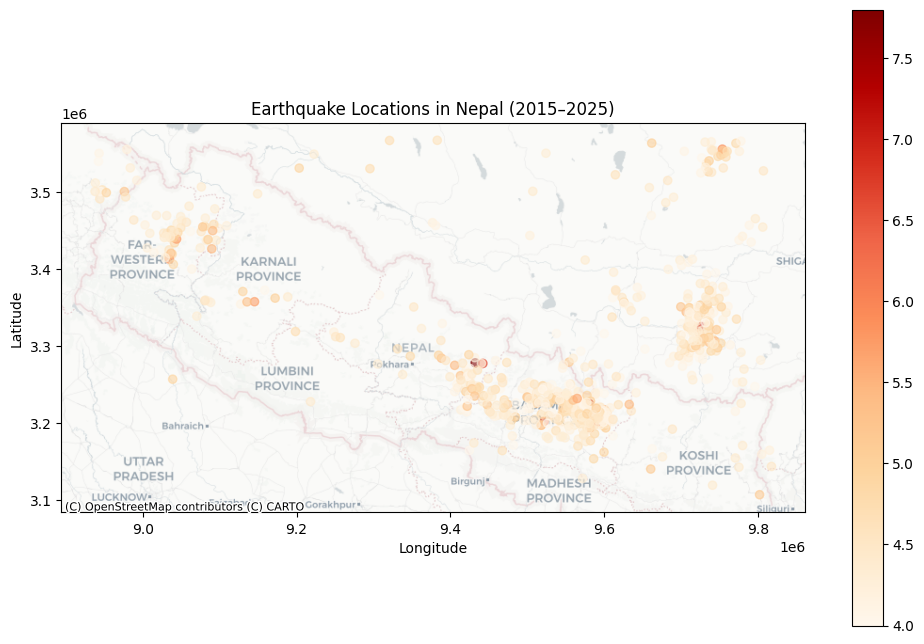

In [25]:
# 12.1 Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']))  # Create GeoDataFrame with point geometry
gdf.crs = "EPSG:4326"  # Set coordinate reference system to WGS84 (latitude/longitude)

# 12.2 Convert to Web Mercator
gdf_3857 = gdf.to_crs(epsg=3857)  # Reproject GeoDataFrame to Web Mercator for web mapping

# 12.3 Plot on CartoDB basemap
ax = gdf_3857.plot(figsize=(12,8), alpha=0.6, column='Magnitude', cmap='OrRd', legend=True)  # Plot points colored by magnitude
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)  # Add CartoDB Positron basemap underneath
plt.title("Earthquake Locations in Nepal (2015–2025)")  # Title
plt.xlabel("Longitude")  # X-axis label
plt.ylabel("Latitude")  # Y-axis label
plt.savefig("earthquake_map_nepal_carto.png", dpi=300, bbox_inches='tight')  # Save figure
plt.show()  # Display plot


Based on the data, Bagmati Province appears to be a significant earthquake hotspot. It is crucial for the government to focus disaster preparedness efforts in this region by implementing early warning systems, strengthening building codes, and conducting regular community awareness programs. Additionally, investing in resilient infrastructure and emergency response training will help minimize the impact of future earthquakes. Proactive measures like these will protect lives, reduce economic losses, and ensure that both the residents and the government of Nepal are better prepared for any upcoming seismic events.



##Finding

The average magnitude of earthquakes in my data is about 4.47, with the smallest recorded at 4.0 and the largest reaching 7.8.

When I look at the relationship between earthquake location (latitude and longitude) and their magnitude or depth, there’s no strong linear correlation. This makes sense because earthquake strength and depth depend more on underground fault lines, tectonic plate boundaries, and stress, rather than just surface coordinates.

The year 2015 stands out with a massive spike in earthquake frequency — over 120 events, which matches the major Gorkha Earthquake and its aftershocks. After 2015, from 2016 to 2025, earthquake activity dropped to a stable, low frequency of fewer than 20 events per year, confirming that 2015 was an exceptional year and not the start of a continuing trend.

From the histogram of magnitudes, I see that:

Most earthquakes are low magnitude, mainly between 4.0 and 5.0.

The number of earthquakes drops sharply as magnitude increases, creating a right-skewed distribution.

Large earthquakes (above 6.5 or 7.0) were rare but did happen during this period.

This means that while earthquakes are frequent, most are mild, with occasional severe ones having bigger impacts.

The scatter plot shows most quakes clustered around the central region of Nepal (lat 28–28.5, lon 84–85). Here, the strongest quakes (yellow color) occurred, especially around the Gorkha event in 2015. Smaller quakes (blue) are more spread out in other areas, indicating many aftershocks and minor events around the main quake zone.

The heatmap highlights the earthquake count by month and year, showing clear spikes in April and May 2015 (Gorkha earthquake period) and another rise in January 2025. Outside these peaks, earthquake activity remains low and stable.

Both box plots with year and month confirm that April and May 2015 had many large magnitude outliers, consistent with the major seismic event. Other times show fewer and smaller magnitude quakes.

From my sample of 30 earthquakes, I notice Sindupalchowk has the most earthquakes (6), followed by Kavrepalanchok (4), Nuwakot (3), and Gorkha (3). These districts are known seismic hotspots because they are near major fault lines. This tells me these areas deserve more attention for earthquake preparedness.

I recognize that 30 earthquakes is just a small snapshot, so I plan to analyze more data for a fuller picture of seismic trends across Nepal.

🧠 Earthquake Analysis Summary (Simple English, Full of Meaning)
In this dataset, the average earthquake magnitude is about 4.47, where the smallest was 4.0 and the biggest reached 7.8.

When I checked the connection between earthquake location (latitude and longitude) and their magnitude or depth, I didn’t find any strong relationship. That’s normal — because the real reasons behind earthquakes are under the ground like tectonic plates, fault lines, and stress — not just the surface location.

In the year 2015, we saw a huge spike in earthquake numbers — more than 120 earthquakes happened. This matches with the big Gorkha Earthquake and its aftershocks. After that, from 2016 to 2025, the earthquake count became low and stable, with fewer than 20 events per year. This clearly shows that 2015 was special, not the beginning of a new trend.

The magnitude histogram shows that:

Most earthquakes were small, between 4.0 and 5.0.

The number of earthquakes goes down fast as the magnitude increases.

Big earthquakes (above 6.5 or 7.0) were rare, but they still happened.

This means earthquakes are common, but most are not dangerous. However, when big ones happen, they cause serious damage.

From the scatter plot, I found that many earthquakes happened in the central part of Nepal, especially between latitude 28–28.5 and longitude 84–85. This is where the strongest ones occurred — especially during the 2015 Gorkha event. Smaller earthquakes (aftershocks) were spread in other places.

The heatmap of monthly data shows big spikes in April and May 2015, which is again related to Gorkha Earthquake. Also, there was a small rise in January 2025. Other than these, earthquake numbers are low in all months and years.

The box plots also prove that April and May 2015 had many big earthquakes, and in other times, earthquakes were fewer and smaller.

**Earthquake Hotspot**: Bagmati Province
From this data, we can clearly say that Bagmati Province is a major hotspot for earthquakes. That’s why it is very important for the Nepal government and local people to take serious action.

**What Should We Do? (Suggestions)**
Here are some simple but powerful ideas to reduce risk and save lives:


*   Early Warning System: Government should install systems that give quick alerts before earthquakes hit.

* Strong Building Rules: Old buildings should be repaired, and new ones should follow earthquake-safe design codes.


* Public Awareness Programs: Local people should learn what to do during earthquakes — like drop, cover, and hold — by running training, drills, and campaigns.

*  Disaster Training for Emergency Teams: We need well-trained teams (police, army, rescue) with tools and quick response systems.




*   Better Infrastructure: Build strong roads, hospitals, communication towers, and shelters that can survive earthquakes.

*   Research and Monitoring: Keep collecting earthquake data and study the patterns using technology and science.

**Conclusion**

If we focus on preparedness, education, and strong planning, we can save many lives in the future. The Gorkha Earthquake in 2015 taught us a big lesson — now it’s time to take action and be ready for whatever comes next.

Together, both the Nepal Government and the citizens can build a safe and strong future.